#Import

In [ ]:

import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Funciones


In [ ]:
import numpy as np
import random
import math


seeds = [42, 142, 244, 5, 74]
path="/content/drive/MyDrive/Datos/resultados_algoritmos.csv"


def leerFichero(file_path):
    with open(file_path, 'r') as f:
        n = int(f.readline().strip())


        lines = [line.strip() for line in f if line.strip() != '']

        all_numbers = []
        for line in lines:
            all_numbers.extend(map(int, line.split()))

        total_vals = n * n
        A_vals = all_numbers[:total_vals]
        B_vals = all_numbers[total_vals:2 * total_vals]

        A = np.array(A_vals).reshape((n, n))
        B = np.array(B_vals).reshape((n, n))

    return n, A, B


def funcionObjetivo( S,A, B):

    S = np.array(S)


    B_permutado = B[np.ix_(S, S)]

    coste = np.sum(A * B_permutado)

    return coste
def funcionObjetivoG(S, A, B):
    S = np.array(S)

    A_recortado = A[np.ix_(S, S)]
    B_permutado = B[np.ix_(S, S)]

    coste = np.sum(A_recortado * B_permutado)

    return coste

def greedy(n, A, B):
    candidatos = list(range(n))
    solucion = []

    while candidatos:
        mejor_candidato = None
        mejor_coste = float('inf')

        for candidato in candidatos:
            sol_temp = solucion + [candidato]
            coste_temp = funcionObjetivoG(sol_temp, A, B)

            if coste_temp < mejor_coste:
                mejor_coste = coste_temp
                mejor_candidato = candidato

        solucion.append(mejor_candidato)
        candidatos.remove(mejor_candidato)

    return solucion, funcionObjetivo(solucion, A, B)


def busquedaAleatoria(n, A, B, iteraciones):
    contador = 0
    mejor = None
    mejorC = float('inf')
    historial_costes = []

    for i in range(iteraciones):
        sol = np.random.permutation(n)
        coste = funcionObjetivo(sol, A, B)
        contador += 1

        if coste < mejorC:
            mejor, mejorC = sol, coste

        historial_costes.append(mejorC)

    return mejor, mejorC, contador, historial_costes





def busquedaLocalMejorVecino(n, A, B):
    Sact = np.random.permutation(n)
    Cact = funcionObjetivo(Sact, A, B)
    contador = 1
    historial_costes = [Cact]

    while True:
        MejorV = None
        MejorVC = float('inf')

        for i in range(n):
            for j in range(i + 1, n):
                vecino = Sact.copy()
                vecino[i], vecino[j] = vecino[j], vecino[i]
                Cvec = funcionObjetivo(vecino, A, B)
                contador += 1

                if Cvec < MejorVC:
                    MejorV = vecino
                    MejorVC = Cvec
        historial_costes.append(Cact)
        if MejorVC < Cact:
            Sact = MejorV
            Cact = MejorVC

        else:
            break

    return Sact, Cact, contador, historial_costes



def busquedaLocalPrimerVecino(n, A, B):
    Sact = np.random.permutation(n)
    Cact = funcionObjetivo(Sact, A, B)
    contador = 1
    historial_costes = [Cact]

    while True:
        MejorV = None
        MejorVC = Cact
        mejora_encontrada = False
        lista = np.random.permutation(n)

        for i in range(n):
            for j in range(i + 1, n):
                vecino = Sact.copy()
                vecino[lista[i]], vecino[lista[j]] = vecino[lista[j]], vecino[lista[i]]
                Cvec = funcionObjetivo(vecino, A, B)
                contador += 1

                if Cvec < MejorVC:
                    MejorV = vecino
                    MejorVC = Cvec
                    mejora_encontrada = True
                    break
            if mejora_encontrada:
                break
        historial_costes.append(Cact)
        if mejora_encontrada:
            Sact = MejorV
            Cact = MejorVC

        else:
            break

    return Sact, Cact, contador, historial_costes


def temperatura_inicial(costo_inicial, phi=0.3, mu=0.3):
    return - (mu * costo_inicial) / math.log(phi)
def seleccionar_vecino(solucion):
    vecino = solucion.copy()
    i, j = random.sample(range(len(solucion)), 2)
    vecino[i], vecino[j] = vecino[j], vecino[i]
    return vecino
def enfriamientoSimulado(n, A, B, phi=0.3, mu=0.3):
    solucion_actual = np.random.permutation(n)
    valor_solucion_actual = funcionObjetivo(solucion_actual, A, B)

    mejor_solucion = solucion_actual.copy()
    valor_mejor_solucion = valor_solucion_actual

    T0 = temperatura_inicial(valor_solucion_actual, phi, mu)
    temperatura = T0

    iteracion = 0
    contador_evaluaciones = [0]
    max_iteraciones = 50 * n

    historial_costes = [valor_mejor_solucion]

    while iteracion < max_iteraciones:
        aceptados = 0
        generados = 0

        while generados < 40 and aceptados < 5:
            vecino = seleccionar_vecino(solucion_actual)
            solucion_candidata = vecino
            valor_candidata = funcionObjetivo(solucion_candidata, A, B)
            contador_evaluaciones[0] += 1
            generados += 1

            delta = valor_candidata - valor_solucion_actual

            try:
                probabilidad_aceptacion = math.exp(-delta / temperatura)
            except (ZeroDivisionError, OverflowError):
                probabilidad_aceptacion = float('inf')

            if delta < 0 or random.uniform(0, 1) < probabilidad_aceptacion:
                solucion_actual = solucion_candidata
                valor_solucion_actual = valor_candidata
                aceptados += 1

                if valor_solucion_actual < valor_mejor_solucion:
                    mejor_solucion = solucion_actual.copy()
                    valor_mejor_solucion = valor_solucion_actual

        iteracion += 1
        temperatura = T0 / (1 + iteracion)
        historial_costes.append(valor_mejor_solucion)

    return mejor_solucion, valor_mejor_solucion, contador_evaluaciones, historial_costes

def ruleta_probabilidades_inversa(frecuencias):
    inversos = []
    for f in frecuencias:
        if f > 0:
            inversos.append(1 / f)
        else:
            inversos.append(1000000)

    suma = sum(inversos)
    probabilidades = []
    for inv in inversos:
        probabilidades.append(inv / suma)

    eleccion = np.random.choice(len(frecuencias), p=probabilidades)
    return eleccion


def greedy_con_memoria(matriz_memoria):
    n = matriz_memoria.shape[0]
    asignacion = [-1] * n
    disponibles = list(range(n))

    for i in range(n):
        fila = matriz_memoria[i, disponibles]
        pos = ruleta_probabilidades_inversa(fila)
        asignacion[i] = disponibles[pos]
        disponibles.pop(pos)

    return asignacion

def busquedaTabu(n, A, B, max_iteraciones=None, semilla=None):
    if semilla is not None:
        random.seed(semilla)
        np.random.seed(semilla)

    if max_iteraciones is None:
        max_iteraciones = 40 * n

    reinicios = 4
    cada_cuanto_reiniciar = max_iteraciones // reinicios

    actual = list(np.random.permutation(n))
    coste_actual = funcionObjetivo(actual, A, B)

    mejor = actual[:]
    mejor_coste = coste_actual

    memoria = np.zeros((n, n), dtype=int)

    tam_tabu = 2
    lista_tabu = [None] * tam_tabu
    indice_tabu = 0
    movimientos_tabu = set()

    evaluaciones = 1
    mejor_vecino_era_tabu = 0
    mejor_vecino_era_tabuyentro=0
    historial_costes = [mejor_coste]

    for i in range(max_iteraciones):
        vecinos = []
        for _ in range(40):
            x, y = sorted(random.sample(range(n), 2))
            nuevo = actual[:]
            nuevo[x], nuevo[y] = nuevo[y], nuevo[x]
            mov = (x, y)
            coste = funcionObjetivo(nuevo, A, B)
            vecinos.append((nuevo, coste, mov))
            evaluaciones += 1

        vecinos.sort(key=lambda item: item[1])

        vecino_top, coste_top, mov_top = vecinos[0]
        if mov_top in movimientos_tabu:
            mejor_vecino_era_tabu += 1
            if coste_top < mejor_coste:
              mejor_vecino_era_tabuyentro += 1





        for vecino, coste, mov in vecinos:
            if mov not in movimientos_tabu or coste < mejor_coste:
                actual = vecino
                coste_actual = coste

                mov_antiguo = lista_tabu[indice_tabu]
                if mov_antiguo is not None:
                    movimientos_tabu.discard(mov_antiguo)

                lista_tabu[indice_tabu] = mov
                movimientos_tabu.add(mov)
                indice_tabu = (indice_tabu + 1) % tam_tabu
                break

        if coste_actual < mejor_coste:
            mejor = actual[:]
            mejor_coste = coste_actual

        for j in range(n):
            memoria[j][actual[j]] += 1

        historial_costes.append(mejor_coste)

        if (i + 1) % cada_cuanto_reiniciar == 0 and (i + 1) < max_iteraciones:
            opcion = random.choices(["aleatoria", "memoria", "mejor"], weights=[0.25, 0.5, 0.25])[0]

            if opcion == "aleatoria":
                actual = list(np.random.permutation(n))
            elif opcion == "memoria":
                actual = greedy_con_memoria(memoria)
            else:
                actual = mejor[:]

            coste_actual = funcionObjetivo(actual, A, B)
            evaluaciones += 1

            if random.random() < 0.5:
                tam_tabu = max(1, int(tam_tabu * 1.5))
            else:
                tam_tabu = max(1, int(tam_tabu * 0.5))

            lista_tabu = [None] * tam_tabu
            indice_tabu = 0
            movimientos_tabu.clear()

    return mejor, mejor_coste, evaluaciones, mejor_vecino_era_tabu,mejor_vecino_era_tabuyentro, historial_costes
def ejecutarExperimentoTabu(file_path, seeds):
    n, A, B = leerFichero(file_path)

    best_costs = []
    evs=[]
    plt.figure(figsize=(10, 6))

    for seed in seeds:
        random.seed(seed)
        np.random.seed(seed)

        solucion, coste, evaluaciones, vt,mvetye, hc = busquedaTabu(n, A, B, semilla=seed)
        best_costs.append(coste)
        evs.append(evaluaciones)

        plt.plot(hc, label=f"Semilla {seed}")

        print(f"Ejecución {seed}: Mejor costo encontrado = {coste}, Evaluaciones = {evaluaciones}, Veces mejor vecino tabú = {vt}, Entro: {mvetye}")


    media = np.mean(best_costs)
    desviacion = np.std(best_costs)
    coef_var = desviacion / media if media != 0 else 0
    path_limpio = file_path.replace("/content/drive/MyDrive/Datos/", "")
    guardar_resultados(path,'Tabu',path_limpio,seeds,best_costs,evs,media,desviacion)
    print("\nResumen del experimento Tabú:")
    print(f"Media: {media}")
    print(f"Desviación típica: {desviacion}")
    print(f"Coeficiente de variación: {coef_var}")


    plt.title("Evolución del coste - Búsqueda Tabú")
    plt.xlabel("Iteración")
    plt.ylabel("Costo")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def ejecutarExperimentoBA(filename, seeds):
    n, A, B = leerFichero(filename)
    it = 1000 * n
    best_costs = []
    evs=[]

    plt.figure(figsize=(10, 6))

    for seed in seeds:
        random.seed(seed)
        np.random.seed(seed)
        best_solution, best_cost, iteraciones, hc = busquedaAleatoria(n, A, B, it)
        best_costs.append(best_cost)
        evs.append(iteraciones)


        plt.plot(hc, label=f"Semilla {seed}")

        print(f"Ejecución {seed}: Mejor costo encontrado = {best_cost}")


    media = np.mean(best_costs)
    desviacion_tipica = np.std(best_costs)
    coef_var = desviacion_tipica / media if media != 0 else 0

    print("\nResumen del experimento (Búsqueda Aleatoria):")
    print(f"Media: {media}")
    print(f"Desviación típica: {desviacion_tipica}")
    print(f"Coef. de variación: {coef_var}")
    path_limpio = filename.replace("/content/drive/MyDrive/Datos/", "")
    guardar_resultados(path,'BA',path_limpio,seeds,best_costs,evs,media,desviacion_tipica)

    plt.title("Evolución del coste - Búsqueda Aleatoria")
    plt.xlabel("Iteración")
    plt.ylabel("Costo")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



def ejecutarExperimentoBLMV(file_path, seeds):
    n, A, B = leerFichero(file_path)
    best_costs = []
    evs=[]
    plt.figure(figsize=(10, 6))

    for seed in seeds:
        random.seed(seed)
        np.random.seed(seed)
        best_solution, best_cost, iteraciones, hc = busquedaLocalMejorVecino(n, A, B)
        best_costs.append(best_cost)
        evs.append(iteraciones)

        plt.plot(hc, label=f"Semilla {seed}")
        print(f"Ejecución {seed}: Mejor costo encontrado = {best_cost}", iteraciones)

    media = np.mean(best_costs)
    desviacion_tipica = np.std(best_costs)
    coef_var = desviacion_tipica / media if media != 0 else 0

    print("\nResumen del experimento (BL Mejor Vecino):")
    print(f"Media: {media}")
    print(f"Desviación típica: {desviacion_tipica}")
    print(f"Coef. de variación: {coef_var}")
    path_limpio = file_path.replace("/content/drive/MyDrive/Datos/", "")
    guardar_resultados(path,'BLMV',path_limpio,seeds,best_costs,evs,media,desviacion_tipica)
    plt.title("Evolución del coste - BL Mejor Vecino")
    plt.xlabel("Iteración (mejoras)")
    plt.ylabel("Costo")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def ejecutarExperimentoBLPV(file_path, seeds):
    n, A, B = leerFichero(file_path)
    best_costs = []
    evs=[]
    plt.figure(figsize=(10, 6))

    for seed in seeds:
        random.seed(seed)
        np.random.seed(seed)
        best_solution, best_cost, iteraciones, hc = busquedaLocalPrimerVecino(n, A, B)
        best_costs.append(best_cost)
        evs.append(iteraciones)
        plt.plot(hc, label=f"Semilla {seed}")
        print(f"Ejecución {seed}: Mejor costo encontrado = {best_cost}", iteraciones)

    media = np.mean(best_costs)
    desviacion_tipica = np.std(best_costs)
    coef_var = desviacion_tipica / media if media != 0 else 0
    path_limpio = file_path.replace("/content/drive/MyDrive/Datos/", "")
    guardar_resultados(path,'BLPV',path_limpio,seeds,best_costs,evs,media,desviacion_tipica)
    print("\nResumen del experimento (BL Primer Vecino):")
    print(f"Media: {media}")
    print(f"Desviación típica: {desviacion_tipica}")
    print(f"Coef. de variación: {coef_var}")

    plt.title("Evolución del coste - BL Primer Vecino")
    plt.xlabel("Iteración (mejoras)")
    plt.ylabel("Costo")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def ejecutarExperimentoEnfriamiento(file_path, seeds):
    n, A, B = leerFichero(file_path)

    best_costs = []
    evs=[]
    plt.figure(figsize=(10, 6))

    for seed in seeds:
        random.seed(seed)
        np.random.seed(seed)
        best_solution, best_cost, iteraciones, hc = enfriamientoSimulado(n, A, B)
        best_costs.append(best_cost)
        evs.append(iteraciones[0])
        plt.plot(hc, label=f"Semilla {seed}")
        print(f"Ejecución {seed}: Mejor costo encontrado = {best_cost}", iteraciones[0])


    media = np.mean(best_costs)
    desviacion_tipica = np.std(best_costs)
    coeficiente_variacion = desviacion_tipica / media if media != 0 else 0
    path_limpio = file_path.replace("/content/drive/MyDrive/Datos/", "")
    guardar_resultados(path,'Enfriamiento',path_limpio,seeds,best_costs,evs,media,desviacion_tipica)
    print("\nResumen del experimento (Enfriamiento Simulado):")
    print(f"Media de los mejores costos: {media}")
    print(f"Desviación típica: {desviacion_tipica}")
    print(f"Desviación típica normalizada (coeficiente de variación): {coeficiente_variacion}")


    plt.title("Evolución del coste - Enfriamiento Simulado")
    plt.xlabel("Iteración")
    plt.ylabel("Costo")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
def ejecutargExperimentoGreedy(file_path):

    n, A, B = leerFichero(file_path)
    results = []
    best_solution, best_cost = greedy(n, A, B)
    print(f"Ejecución: Mejor costo encontrado = {best_cost}")


In [ ]:

import pandas as pd
def inicializar_csv(nombre_archivo, seeds):
    columnas = ["Algoritmo","Dataset"]

    for seed in seeds:
        columnas.append(f"Seed {seed}")
        columnas.append(f"Ev {seed}")

    columnas += ["Media Coste", "Desviación"]

    # Crear un DataFrame vacío con esas columnas
    df = pd.DataFrame(columns=columnas)
    df.to_csv(nombre_archivo, index=False)
    print(f"Archivo '{nombre_archivo}' inicializado con cabecera.")



import os

def guardar_resultados(nombre_archivo, nombre_algoritmo, dataset,seeds, costes, evaluaciones, media, desviacion):
    fila = {
        "Algoritmo": nombre_algoritmo,
        "Dataset": dataset
    }

    for i in range(len(seeds)):
        fila[f"Seed {seeds[i]}"] = costes[i]
        fila[f"Ev {seeds[i]}"] = evaluaciones[i]

    fila["Media Coste"] = media
    fila["Desviación"] = desviacion

    # Si el archivo existe, lo cargamos y añadimos una nueva fila
    if os.path.exists(nombre_archivo):
        df = pd.read_csv(nombre_archivo)
        df = pd.concat([df, pd.DataFrame([fila])], ignore_index=True)
    else:
        # Si no existe, lo creamos con esta primera fila
        df = pd.DataFrame([fila])

    df.to_csv(nombre_archivo, index=False)
    print(f"Resultados guardados en {nombre_archivo}")

#Codigo

In [ ]:
seeds = [42, 142, 244, 5, 74]
inicializar_csv("/content/drive/MyDrive/Datos/resultados_algoritmos.csv", seeds)

Archivo '/content/drive/MyDrive/Datos/resultados_algoritmos.csv' inicializado con cabecera.


In [ ]:

ejecutargExperimentoGreedy('/content/drive/MyDrive/Datos/tai25b.dat')
ejecutargExperimentoGreedy('/content/drive/MyDrive/Datos/sko90.dat')
ejecutargExperimentoGreedy('/content/drive/MyDrive/Datos/tai150b.dat')

Ejecución: Mejor costo encontrado = 1020047401
Ejecución: Mejor costo encontrado = 140136
Ejecución: Mejor costo encontrado = 688800147


#Ejecucion

Ejecución 42: Mejor costo encontrado = 345475531 46438
Ejecución 142: Mejor costo encontrado = 347562683 45936
Ejecución 244: Mejor costo encontrado = 347603820 46738
Ejecución 5: Mejor costo encontrado = 344355646 46318
Ejecución 74: Mejor costo encontrado = 346483036 46354
Resultados guardados en /content/drive/MyDrive/Datos/resultados_algoritmos.csv

Resumen del experimento (Enfriamiento Simulado):
Media de los mejores costos: 346296143.2
Desviación típica: 1248038.8105288073
Desviación típica normalizada (coeficiente de variación): 0.003603963933863435


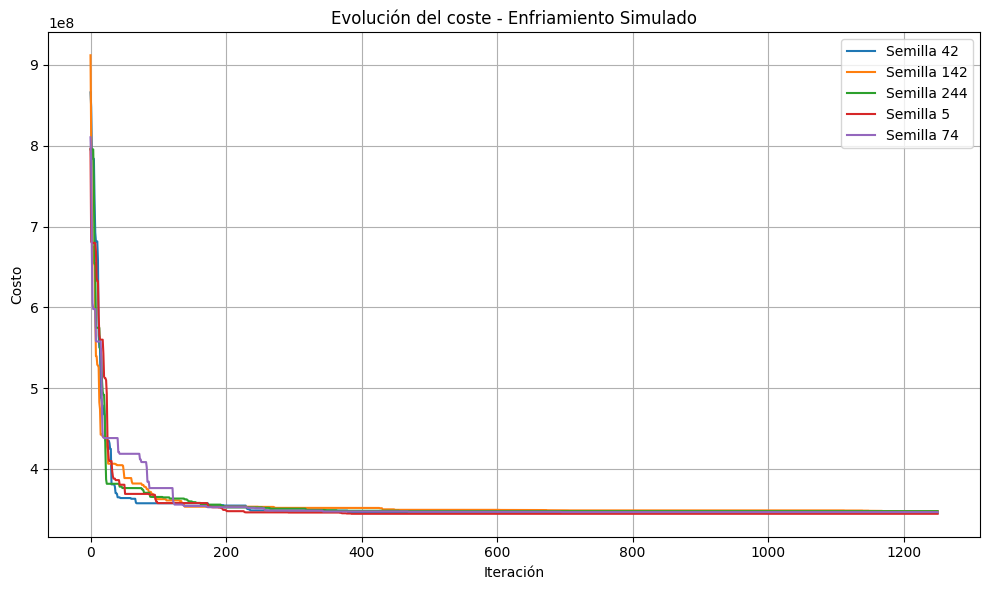

Ejecución 42: Mejor costo encontrado = 116174 167654
Ejecución 142: Mejor costo encontrado = 116142 167363
Ejecución 244: Mejor costo encontrado = 116586 167205
Ejecución 5: Mejor costo encontrado = 116450 167888
Ejecución 74: Mejor costo encontrado = 115858 167550
Resultados guardados en /content/drive/MyDrive/Datos/resultados_algoritmos.csv

Resumen del experimento (Enfriamiento Simulado):
Media de los mejores costos: 116242.0
Desviación típica: 254.43270230062802
Desviación típica normalizada (coeficiente de variación): 0.0021888190352938527


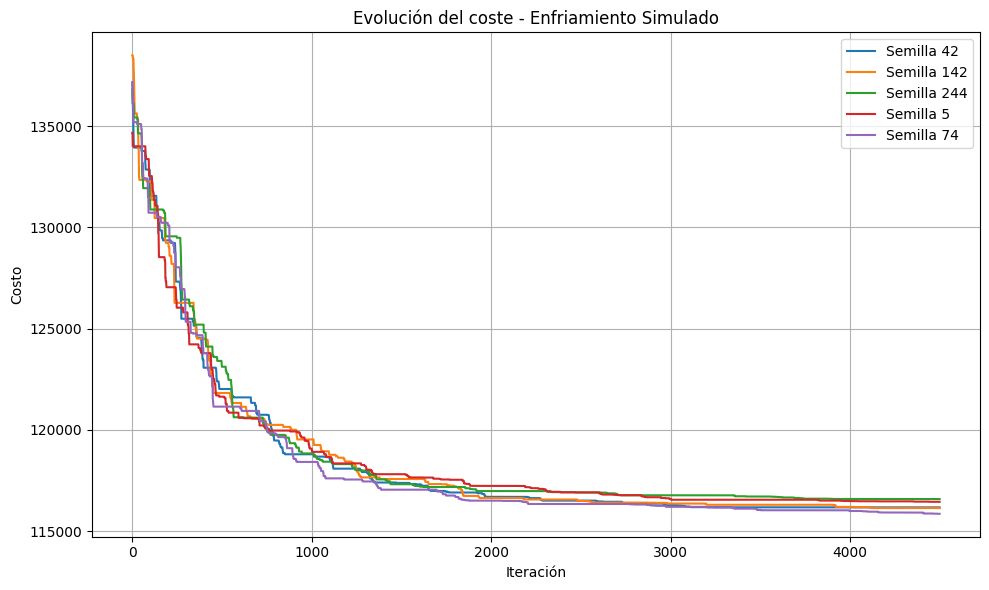

Ejecución 42: Mejor costo encontrado = 506269512 279846
Ejecución 142: Mejor costo encontrado = 506420850 280421
Ejecución 244: Mejor costo encontrado = 506796572 279910
Ejecución 5: Mejor costo encontrado = 509759586 279107
Ejecución 74: Mejor costo encontrado = 503546460 280086
Resultados guardados en /content/drive/MyDrive/Datos/resultados_algoritmos.csv

Resumen del experimento (Enfriamiento Simulado):
Media de los mejores costos: 506558596.0
Desviación típica: 1973751.5729566372
Desviación típica normalizada (coeficiente de variación): 0.003896393405505722


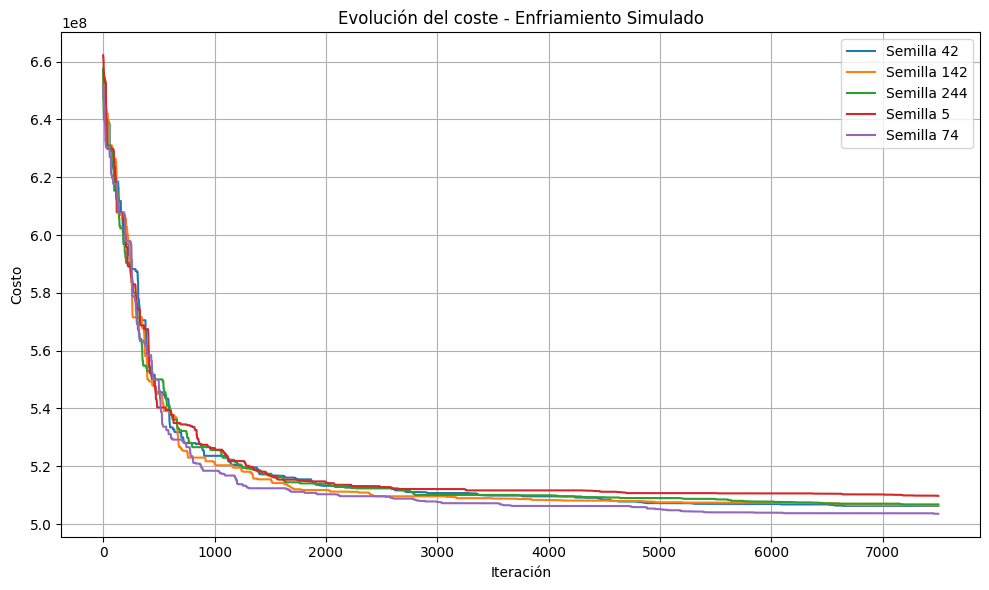

Ejecución 42: Mejor costo encontrado = 369917567 1353
Ejecución 142: Mejor costo encontrado = 351136058 2357
Ejecución 244: Mejor costo encontrado = 389362525 1566
Ejecución 5: Mejor costo encontrado = 406231549 2701
Ejecución 74: Mejor costo encontrado = 426217213 1134
Resultados guardados en /content/drive/MyDrive/Datos/resultados_algoritmos.csv

Resumen del experimento (BL Primer Vecino):
Media: 388572982.4
Desviación típica: 26378340.666644286
Coef. de variación: 0.06788516407836669


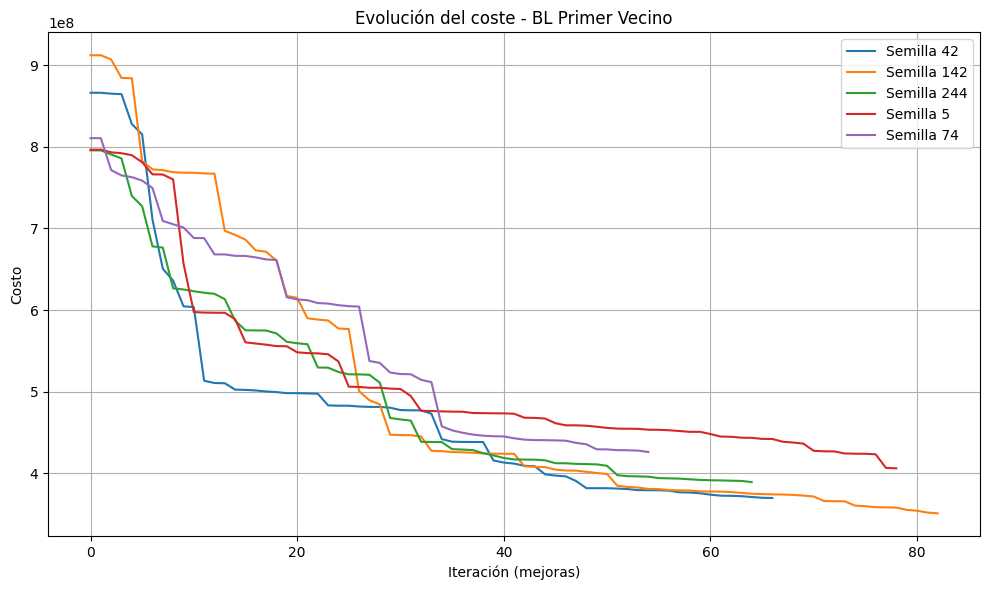

Ejecución 42: Mejor costo encontrado = 117260 44313
Ejecución 142: Mejor costo encontrado = 117196 35892
Ejecución 244: Mejor costo encontrado = 118430 30014
Ejecución 5: Mejor costo encontrado = 118228 27234
Ejecución 74: Mejor costo encontrado = 118412 53118
Resultados guardados en /content/drive/MyDrive/Datos/resultados_algoritmos.csv

Resumen del experimento (BL Primer Vecino):
Media: 117905.2
Desviación típica: 557.8008246677304
Coef. de variación: 0.004730926410944813


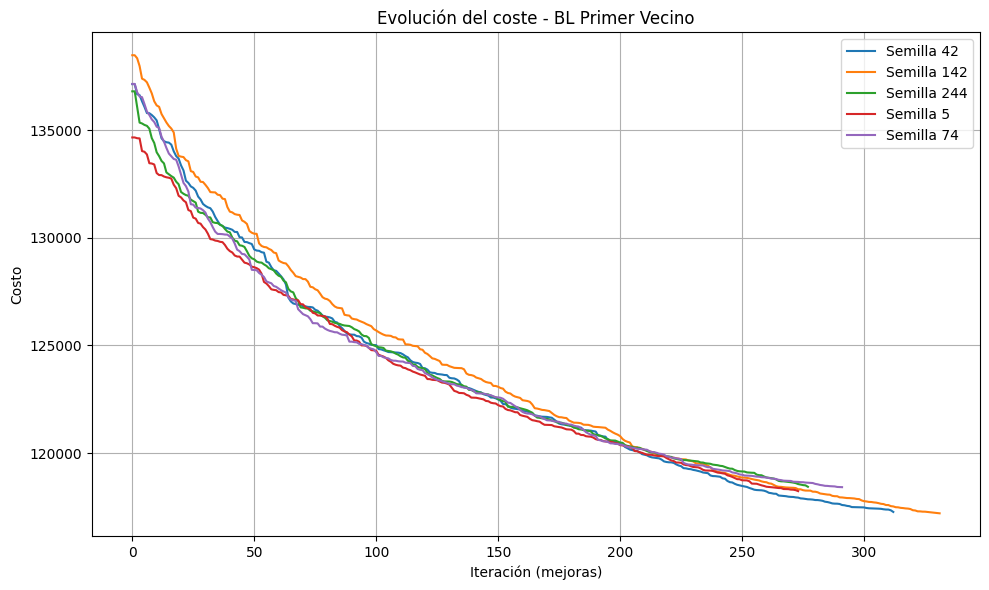

Ejecución 42: Mejor costo encontrado = 511655932 204909
Ejecución 142: Mejor costo encontrado = 506834269 182497
Ejecución 244: Mejor costo encontrado = 513628887 160112
Ejecución 5: Mejor costo encontrado = 513904827 184870
Ejecución 74: Mejor costo encontrado = 513084492 172793
Resultados guardados en /content/drive/MyDrive/Datos/resultados_algoritmos.csv

Resumen del experimento (BL Primer Vecino):
Media: 511821681.4
Desviación típica: 2611587.011539811
Coef. de variación: 0.0051025329845274725


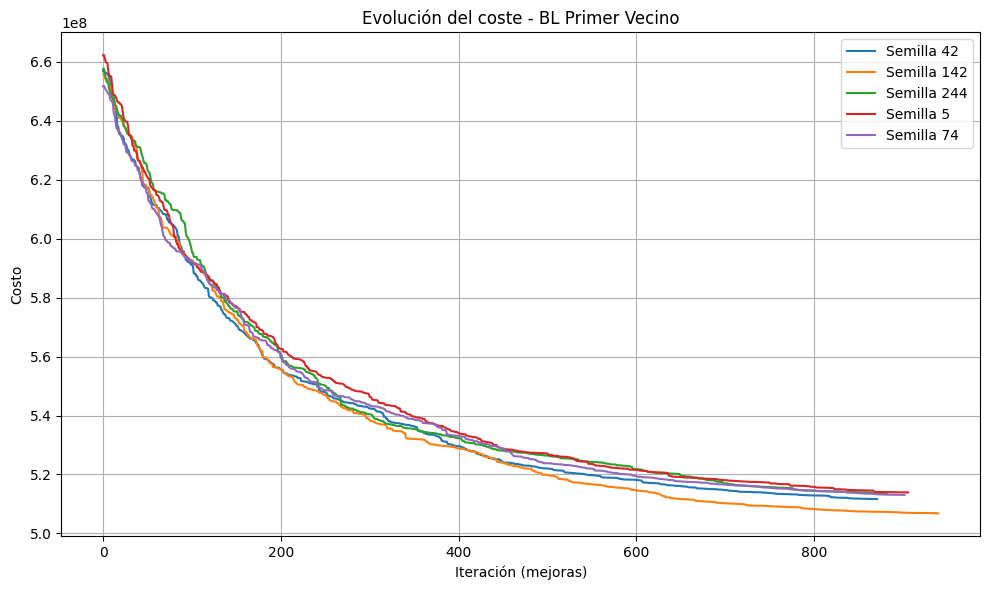

Ejecución 42: Mejor costo encontrado = 475293614
Ejecución 142: Mejor costo encontrado = 474493243
Ejecución 244: Mejor costo encontrado = 463407604
Ejecución 5: Mejor costo encontrado = 498498888
Ejecución 74: Mejor costo encontrado = 494553376

Resumen del experimento (Búsqueda Aleatoria):
Media: 481249345.0
Desviación típica: 13221099.36765968
Coef. de variación: 0.02747245166153874
Resultados guardados en /content/drive/MyDrive/Datos/resultados_algoritmos.csv


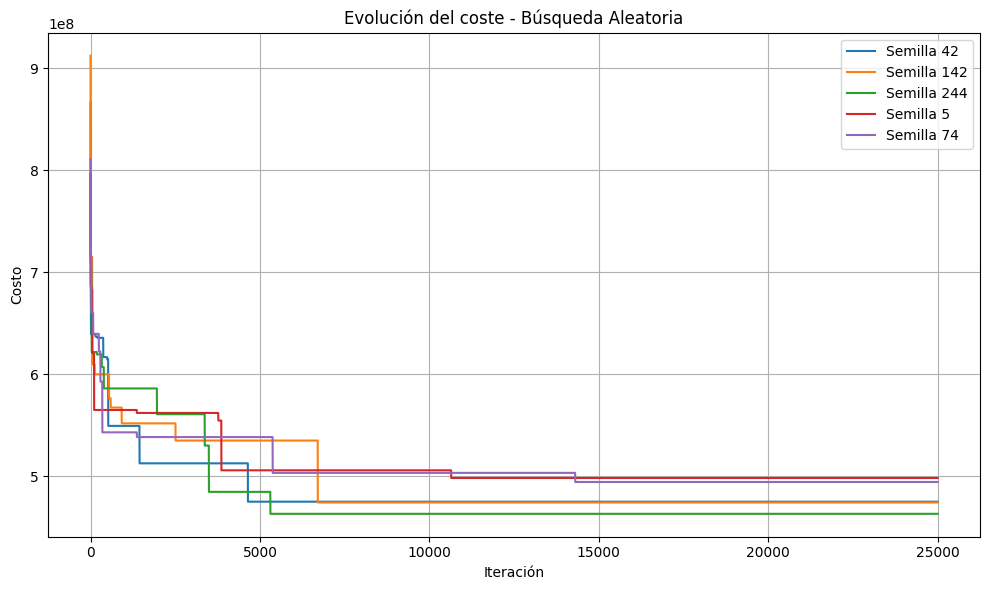

Ejecución 42: Mejor costo encontrado = 132422
Ejecución 142: Mejor costo encontrado = 132226
Ejecución 244: Mejor costo encontrado = 131796
Ejecución 5: Mejor costo encontrado = 132114
Ejecución 74: Mejor costo encontrado = 131838

Resumen del experimento (Búsqueda Aleatoria):
Media: 132079.2
Desviación típica: 236.07320898399294
Coef. de variación: 0.001787360984803004
Resultados guardados en /content/drive/MyDrive/Datos/resultados_algoritmos.csv


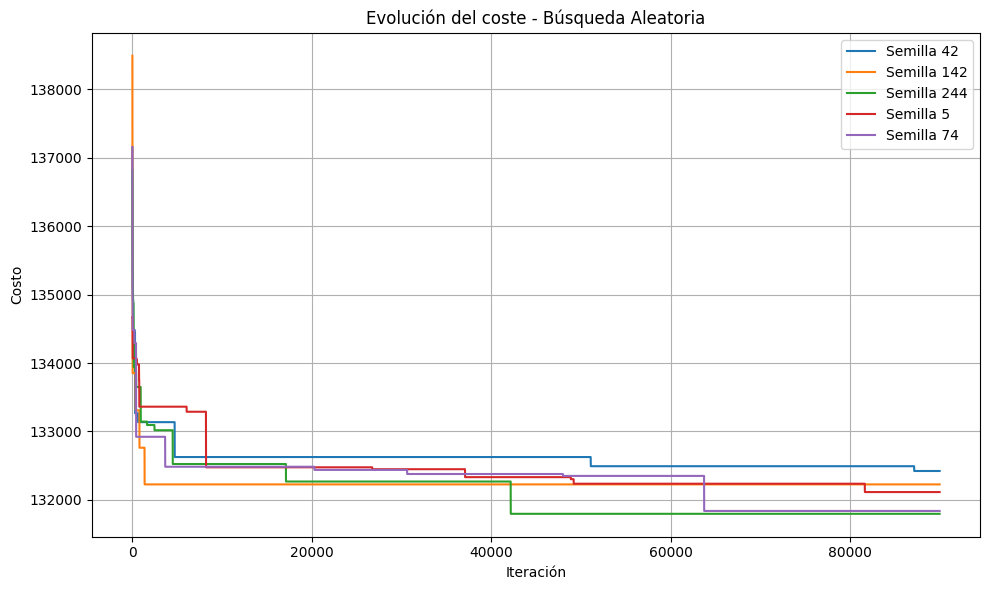

Ejecución 42: Mejor costo encontrado = 622934645
Ejecución 142: Mejor costo encontrado = 619245713
Ejecución 244: Mejor costo encontrado = 622420493
Ejecución 5: Mejor costo encontrado = 620305714
Ejecución 74: Mejor costo encontrado = 618147853

Resumen del experimento (Búsqueda Aleatoria):
Media: 620610883.6
Desviación típica: 1827451.351642675
Coef. de variación: 0.0029446008762239423
Resultados guardados en /content/drive/MyDrive/Datos/resultados_algoritmos.csv


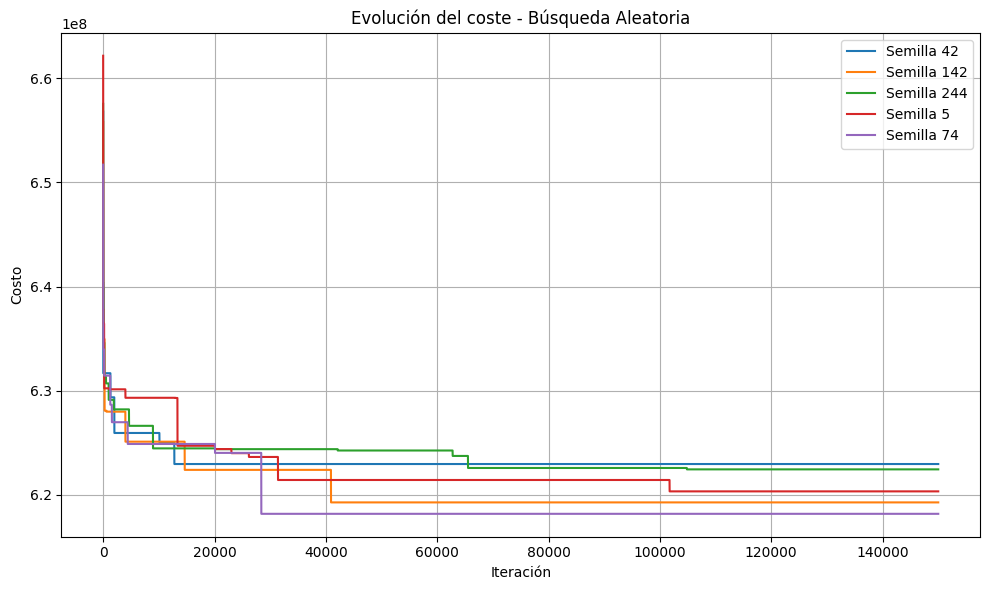

Ejecución 42: Mejor costo encontrado = 348289925, Evaluaciones = 40004, Veces mejor vecino tabú = 174, Entro: 7
Ejecución 142: Mejor costo encontrado = 345582843, Evaluaciones = 40004, Veces mejor vecino tabú = 57, Entro: 1
Ejecución 244: Mejor costo encontrado = 381705718, Evaluaciones = 40004, Veces mejor vecino tabú = 171, Entro: 1
Ejecución 5: Mejor costo encontrado = 364189862, Evaluaciones = 40004, Veces mejor vecino tabú = 73, Entro: 2
Ejecución 74: Mejor costo encontrado = 347384489, Evaluaciones = 40004, Veces mejor vecino tabú = 130, Entro: 2
Resultados guardados en /content/drive/MyDrive/Datos/resultados_algoritmos.csv

Resumen del experimento Tabú:
Media: 357430567.4
Desviación típica: 13855068.446631718
Coeficiente de variación: 0.03876296464349825


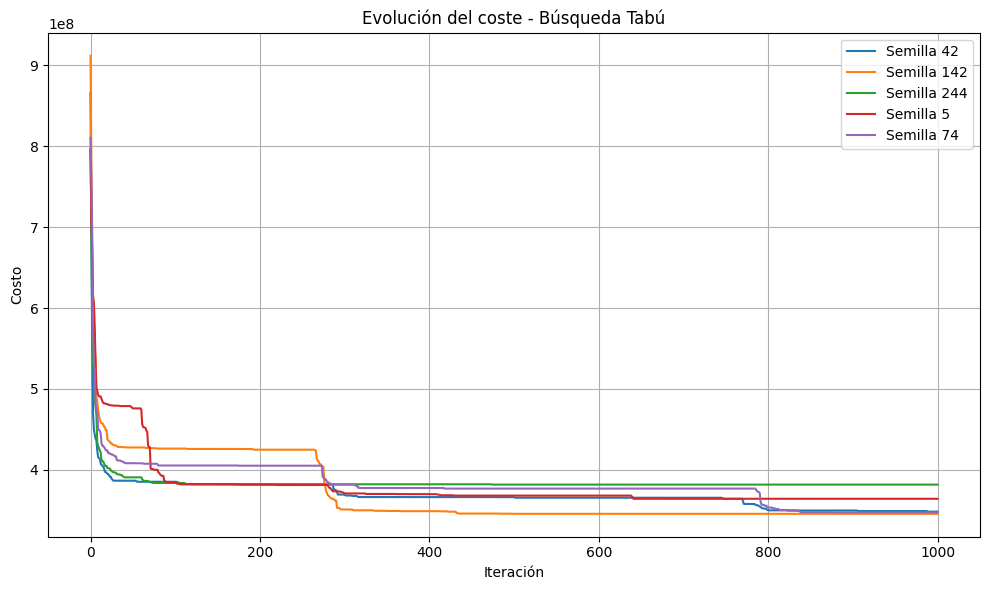

Ejecución 42: Mejor costo encontrado = 117530, Evaluaciones = 144004, Veces mejor vecino tabú = 28, Entro: 0
Ejecución 142: Mejor costo encontrado = 117774, Evaluaciones = 144004, Veces mejor vecino tabú = 9, Entro: 0
Ejecución 244: Mejor costo encontrado = 117856, Evaluaciones = 144004, Veces mejor vecino tabú = 47, Entro: 0
Ejecución 5: Mejor costo encontrado = 117904, Evaluaciones = 144004, Veces mejor vecino tabú = 31, Entro: 0
Ejecución 74: Mejor costo encontrado = 117708, Evaluaciones = 144004, Veces mejor vecino tabú = 40, Entro: 0
Resultados guardados en /content/drive/MyDrive/Datos/resultados_algoritmos.csv

Resumen del experimento Tabú:
Media: 117754.4
Desviación típica: 130.8397493118968
Coeficiente de variación: 0.0011111240795409498


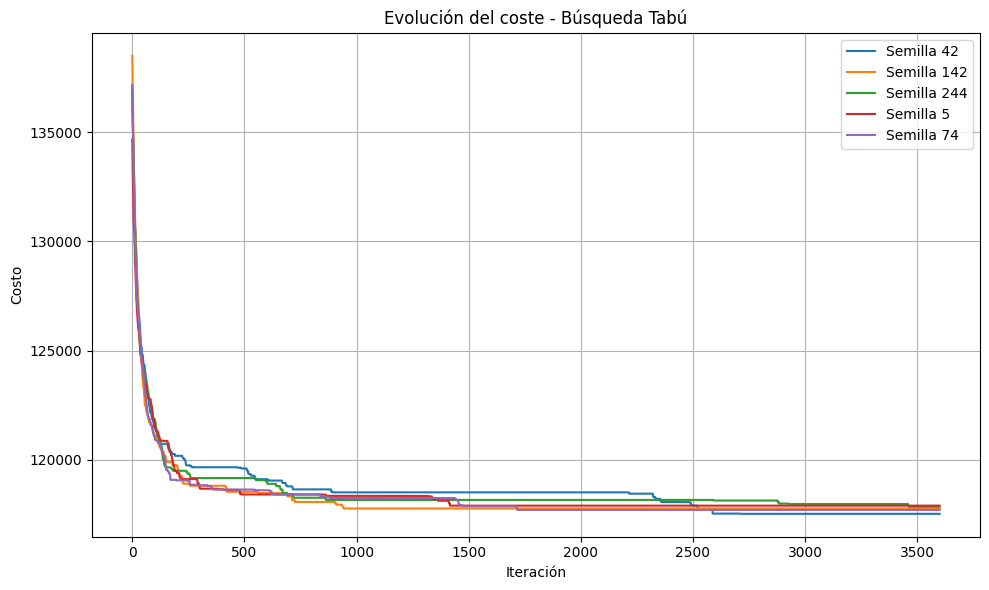

Ejecución 42: Mejor costo encontrado = 509643055, Evaluaciones = 240004, Veces mejor vecino tabú = 10, Entro: 0
Ejecución 142: Mejor costo encontrado = 509487930, Evaluaciones = 240004, Veces mejor vecino tabú = 9, Entro: 0
Ejecución 244: Mejor costo encontrado = 510248365, Evaluaciones = 240004, Veces mejor vecino tabú = 7, Entro: 0
Ejecución 5: Mejor costo encontrado = 513015725, Evaluaciones = 240004, Veces mejor vecino tabú = 25, Entro: 0
Ejecución 74: Mejor costo encontrado = 515581286, Evaluaciones = 240004, Veces mejor vecino tabú = 10, Entro: 0
Resultados guardados en /content/drive/MyDrive/Datos/resultados_algoritmos.csv

Resumen del experimento Tabú:
Media: 511595272.2
Desviación típica: 2365256.6169490702
Coeficiente de variación: 0.004623296471794624


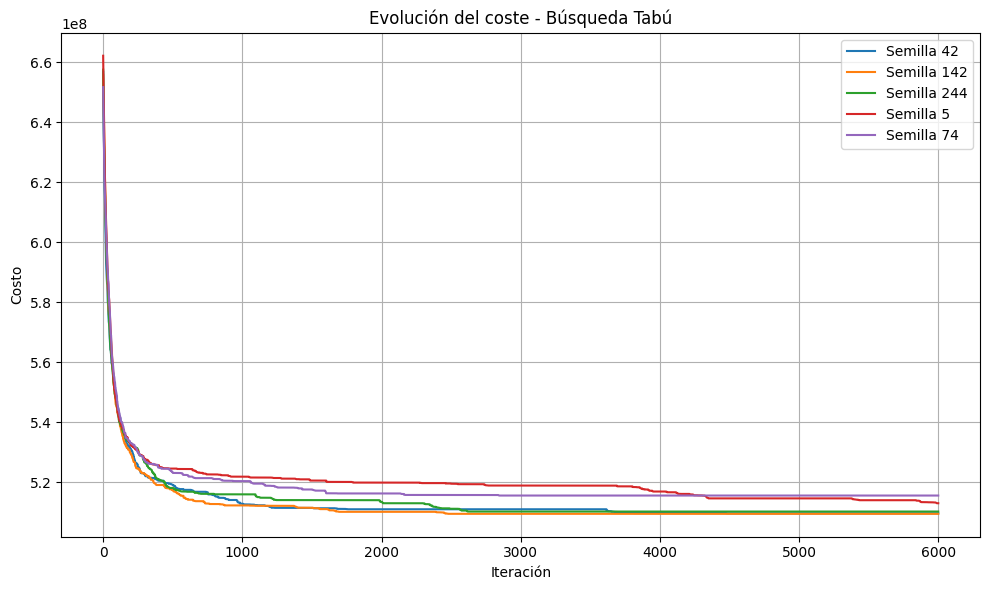

Ejecución 42: Mejor costo encontrado = 383795207 5701
Ejecución 142: Mejor costo encontrado = 420704130 6901
Ejecución 244: Mejor costo encontrado = 423850582 6901
Ejecución 5: Mejor costo encontrado = 466938306 6901
Ejecución 74: Mejor costo encontrado = 512875697 5401

Resumen del experimento (BL Mejor Vecino):
Media: 441632784.4
Desviación típica: 44306484.12110692
Coef. de variación: 0.10032426415376178
Resultados guardados en /content/drive/MyDrive/Datos/resultados_algoritmos.csv


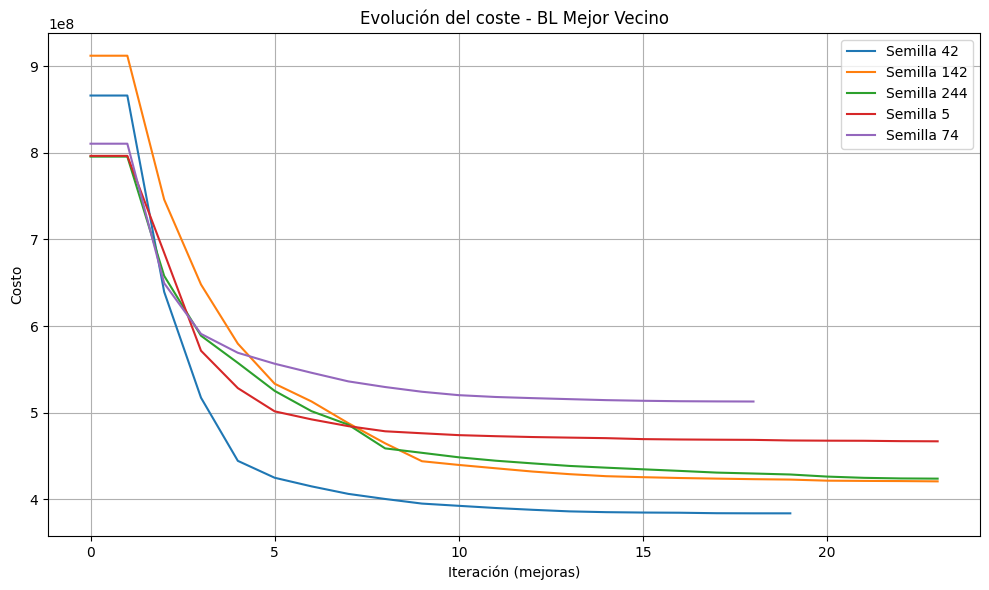

Ejecución 42: Mejor costo encontrado = 117752 392491
Ejecución 142: Mejor costo encontrado = 117722 448561
Ejecución 244: Mejor costo encontrado = 119010 360451
Ejecución 5: Mejor costo encontrado = 117702 628786
Ejecución 74: Mejor costo encontrado = 117816 396496

Resumen del experimento (BL Mejor Vecino):
Media: 118000.4
Desviación típica: 506.27012552588957
Coef. de variación: 0.004290410248828729
Resultados guardados en /content/drive/MyDrive/Datos/resultados_algoritmos.csv


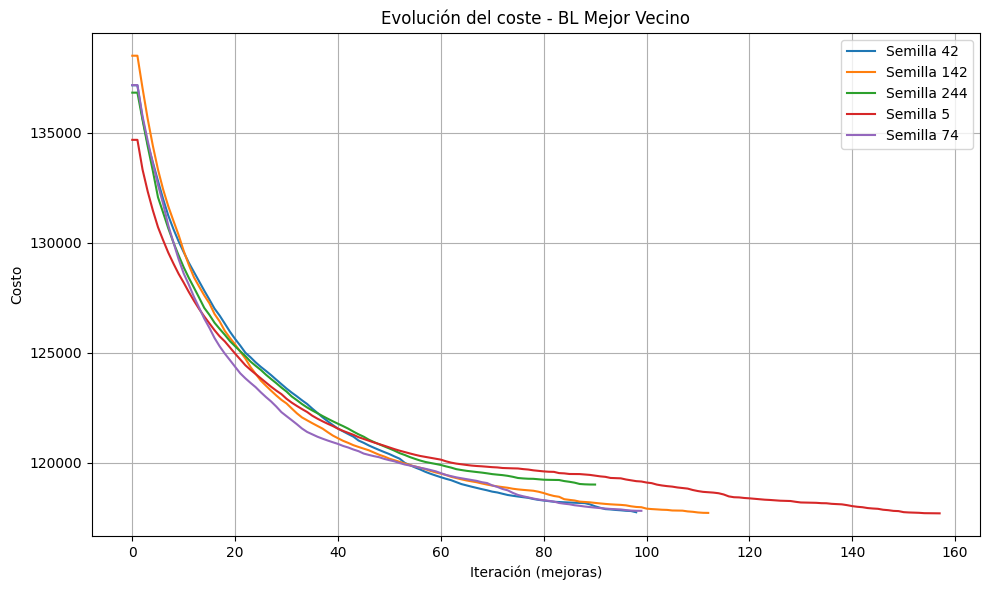

Ejecución 42: Mejor costo encontrado = 509806040 2391451
Ejecución 142: Mejor costo encontrado = 516423663 2480851
Ejecución 244: Mejor costo encontrado = 516413898 2559076
Ejecución 5: Mejor costo encontrado = 523151869 2100901
Ejecución 74: Mejor costo encontrado = 518820286 2045026

Resumen del experimento (BL Mejor Vecino):
Media: 516923151.2
Desviación típica: 4325694.048316935
Coef. de variación: 0.008368156926760094
Resultados guardados en /content/drive/MyDrive/Datos/resultados_algoritmos.csv


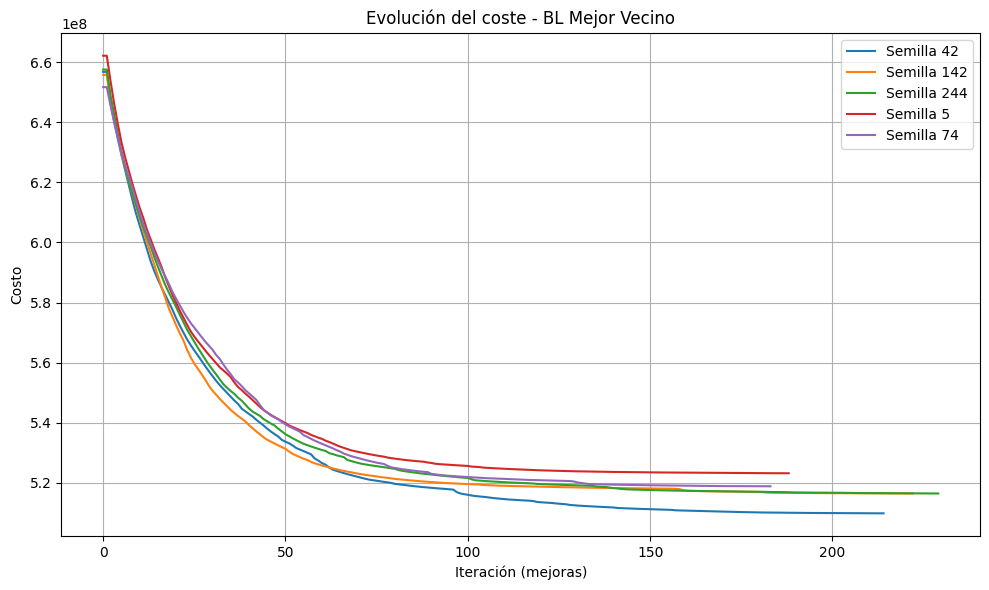

In [ ]:
# Lista de rutas de los datasets
datasets = [
    '/content/drive/MyDrive/Datos/tai25b.dat',
    '/content/drive/MyDrive/Datos/sko90.dat',
    '/content/drive/MyDrive/Datos/tai150b.dat'
]

# Ejecutar todos los experimentos del mismo tipo seguidos

# Enfriamiento
for dataset in datasets:
    ejecutarExperimentoEnfriamiento(dataset, seeds)

# BLPV
for dataset in datasets:
    ejecutarExperimentoBLPV(dataset, seeds)

# BA
for dataset in datasets:
    ejecutarExperimentoBA(dataset, seeds)

# Tabu
for dataset in datasets:
    ejecutarExperimentoTabu(dataset, seeds)

# BLMV (debe ir al final)
for dataset in datasets:
    ejecutarExperimentoBLMV(dataset, seeds)